## Simulate MVARX Data

In the following we use mvarx_data_gen to simulate a train of MVARX data.

First of all we load MVARX model parameters we estimated from past results.

In [1]:
% load MVARX models estimated from Chang, et al. Front Hum Neurosci. 2012; 6: 317. 
load('mdl_cltd.mat', 'mdl_F3_FA_5m')

Then we set the model dimension and model parameters.

In [2]:
m_ori = size(mdl_F3_FA_5m.Aw, 1);    % number of channel in the original model
m = 3;    % number of channels we will be using in this simulation
p = 3;    % MVARX AR order
l = 10;   % MVARX feedforward length

In [3]:
col_set = kron(ones(1, m), 1:p) + kron(0:m_ori:m_ori*(p-1), ones(1, m));
A = mdl_F3_FA_5m.Aw(1:m, col_set);     % MVARX A matrix
B = mdl_F3_FA_5m.Bw(1:m, 1:l);         % MVARX B matrix
Q = 25 * mdl_F3_FA_5m.Qw(1:m, 1:m);    % MVARX Q matrix

Here we scale A properly so that A is stable and the time series don't blow up.

In [4]:
while ~is_stbl(A)
    A = A * 0.9;
end

We use a train of 100 samples of stimulation input with the actual input being inserted at 20th sample.

In [5]:
u = [zeros(1, 19), 1, zeros(1, 80)];  % train of stimulation

In [6]:
X = mvarx_data_gen(A, B, Q, u);

Below we show waterfall plot of the three channels.

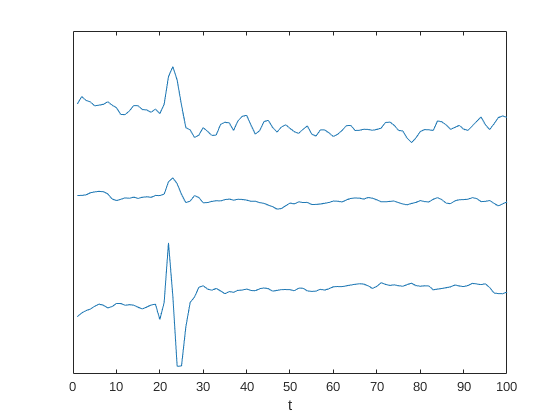

In [7]:
wf_shift = (0:-20:(m-1)*(-20))';
plot((X + wf_shift(:, ones(1, 100)))', 'Color', [31,120,180] / 255);
set(gca, 'ytick', '')
xlabel('t')

Now generate 20 epochs/trials of MVARX data.

In [8]:
n_epoch = 20;
X = cell(1, n_epoch);
for i = 1:n_epoch
    X{i} = mvarx_data_gen(A, B, Q, u);
end

In [9]:
% create a 1-by-20 cell, each cell is the train of stimulation for the epoch
u = num2cell(repmat(u, 1, 1, n_epoch), [1, 2]);   

## Estimate Model

Secify the model dimensions of the model we would like to estimate.

In [10]:
p = 3;
l = 10;

In [11]:
[A_hat, B_hat, Q_hat, W, n_spl] = mvarx_fit(X, u, p, l);

Now we show that the estimated A matrix A_hat is similar to the original A matrix.

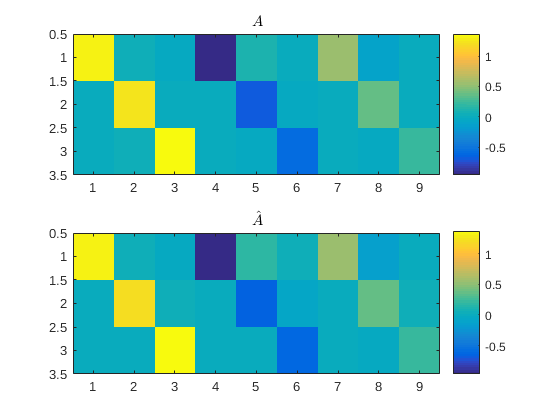

In [12]:
cmin = min([A_hat(:); A(:)]);
cmax = max([A_hat(:); A(:)]);
subplot(211); imagesc(A, [cmin, cmax]); title('$A$', 'Interpreter', 'latex'); colorbar;
subplot(212); imagesc(A_hat, [cmin, cmax]); title('$\hat A$', 'Interpreter', 'latex'); colorbar;

We can also generate model response with mvarx_data_gen.

In [13]:
evoked_response = mean(reshape(cell2mat(X), m, size(u{1},2), []), 3);
model_response = mvarx_data_gen(A_hat, B_hat, [], u{1}, 'evoked', true);

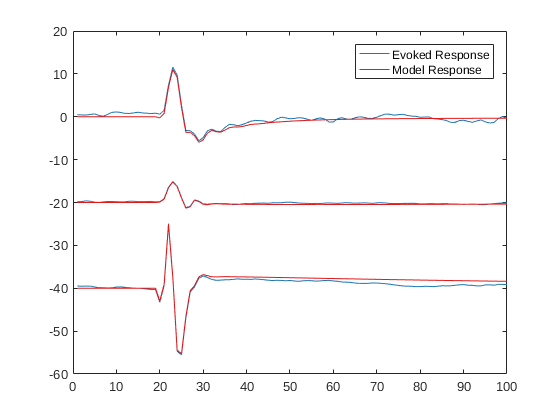

In [14]:
wf_shift = (0:-20:(m-1)*(-20))';
h1 = plot((evoked_response + wf_shift(:, ones(1, 100)))', 'Color', [31,120,180] / 255); hold on;
h2 = plot((model_response + wf_shift(:, ones(1, 100)))', 'Color', [227,26,28] / 255);
legend([h1(1), h2(1)], {'Evoked Response', 'Model Response'})

## Check Residual Whiteness

In the output values of mvarx_residual_whiteness, H is the hypothesis statistics, which under H_0 (the residual is uncorrelated), should be a standard normal random variable. P is the p-value, which is computed as 2 * (1 - normcdf(abs(H)).

In [15]:
[H, p] = mvarx_residual_whiteness(W{1})


H =

    0.5067


p =

    0.6124



There are five kernel functions ('kernel') available: 'TR' (Truncated), 'BAR' (Bartlett (default)), 'DAN', (Daniell), 'PAR' (Parzen), 'QS' (Quadratic-Spectral).

There are also five available memory length $L$ ('L') for the statistics: '2', '3', 'log', 'n_to_point2' (default), 'n_to_point3'.

In [16]:
[H, p] = mvarx_residual_whiteness(cell2mat(W), 'kernel', 'PAR', 'L', 'log')


H =

   -2.4129


p =

    0.0158

